#  Data Visualization Region Proposal Network

In [1]:
import matplotlib.pyplot as plt

In [2]:
import os
from os import path as osp
import numpy as np
import pickle

from utils.utils import geom2pix, ValidityChecker

from skimage import io

In [3]:
import torch
import torch.nn.functional as F
import json

from transformer import Models
from dataLoader import get_encoder_input
try:
    from ompl import base as ob
    from ompl import geometric as og
    from ompl import util as ou
except ImportError:
    raise ImportError("Container does not have OMPL installed")
import time    

###  Load the Map

## Define the Start and Goal Point

(-0.5, 239.5, 239.5, -0.5)

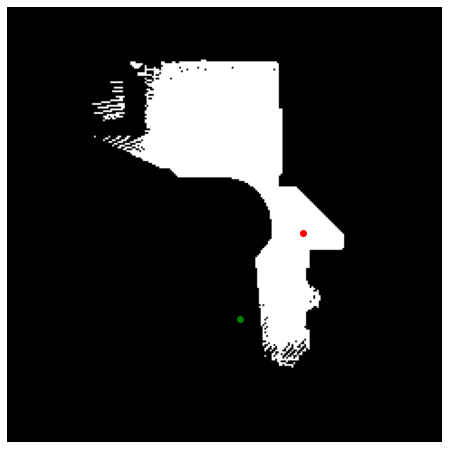

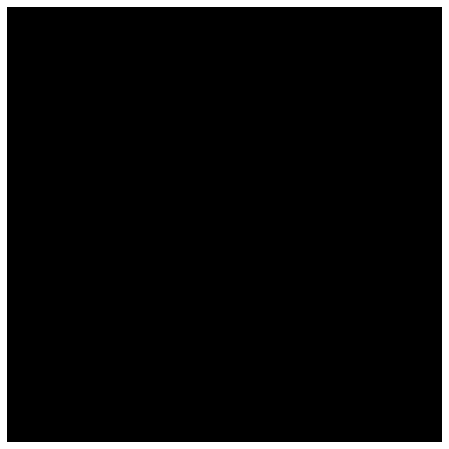

In [32]:
# Plot the patches
env_num =1
stepNum = 1045
envFolder = f'tmp/data/exp1/env{env_num}'
data = pickle.load(open(osp.join(envFolder, f'data{stepNum:06d}.p'), 'rb'))
expMap = np.flipud(data['explored_map'])
collMap = np.flipud(data['collison_map'])
#fig, ax = plt.subplots(figsize=(9, 9))
#ax.imshow(MazeMap, cmap='gray')
#ax.axis('off')

path = data['path_to_go']
start_pos = geom2pix(path[-1, :], size = (240,240))
goal_pos = geom2pix(path[0, :], size=(240,240))

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(expMap, cmap='gray')
ax.scatter(goal_pos[0], goal_pos[1], color='r', zorder=3)
ax.scatter(start_pos[0], start_pos[1], color='g', zorder=3)
ax.axis('off')

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(collMap, cmap='gray')
ax.axis('off')

In [35]:
print(data['collison_map'])


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [23]:
pathPix = [geom2pix(pos,size=(240,240)) for pos in path]

uniqueId = []
for pos in pathPix:
    if pos not in uniqueId:
        uniqueId.append(pos)
pathPixelPos = np.array([geom2pix(pos,size=(240,240)) for pos in data['prm_star_path']['path']])# Generate Patch Maps
truePatchMap = np.zeros_like(MazeMap)
map_size = MazeMap.shape
receptive_field = 32
for pos in uniqueId:
    goal_start_x = max(0, pos[0]- receptive_field//2)
    goal_start_y = max(0, pos[1]- receptive_field//2)
    goal_end_x = min(map_size[0], pos[0]+ receptive_field//2)
    goal_end_y = min(map_size[1], pos[1]+ receptive_field//2)
    truePatchMap[goal_start_y:goal_end_y, goal_start_x:goal_end_x] = 1.0

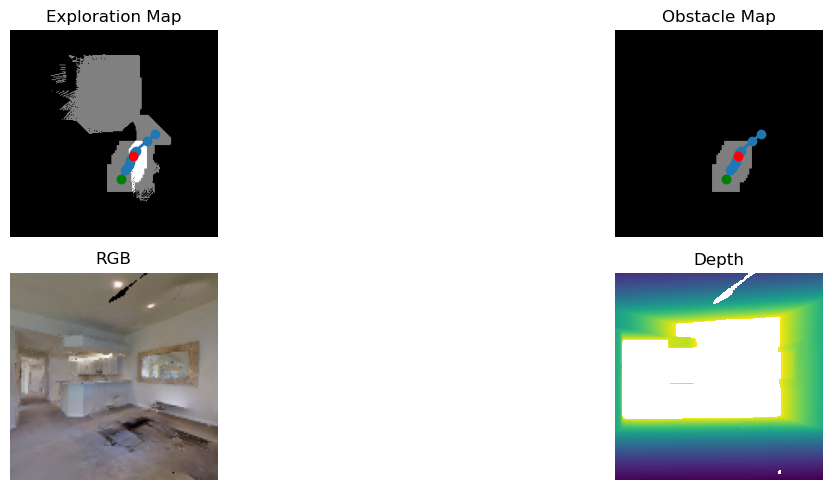

In [24]:
fig, ax = plt.subplots(2, 2, figsize=(16.5,5), dpi=100)

ax[0][0].set_title('Exploration Map')
ax[0][0].imshow(MazeMap, cmap='gray')
ax[0][0].imshow(truePatchMap, cmap='gray', alpha=0.5)
ax[0][0].plot(pathPixelPos[:,0], pathPixelPos[:,1], marker='o', linewidth=2)
ax[0][0].scatter(goal_pos[0], goal_pos[1], color='r', zorder=3)
ax[0][0].scatter(start_pos[0], start_pos[1], color='g', zorder=3)
ax[0][0].axis('off')

ax[0][1].set_title('Obstacle Map')
ax[0][1].imshow(CollMap, cmap='gray')
ax[0][1].imshow(truePatchMap, cmap='gray', alpha=0.5)
ax[0][1].plot(pathPixelPos[:,0], pathPixelPos[:,1], marker='o', linewidth=2)
ax[0][1].scatter(goal_pos[0], goal_pos[1], color='r', zorder=3)
ax[0][1].scatter(start_pos[0], start_pos[1], color='g', zorder=3)
ax[0][1].axis('off')


rgb = data['curr_rgb']
im = ax[1][0].imshow(rgb)
ax[1][0].set_title('RGB')
ax[1][0].axis('off')

rgb = data['curr_depth']
im = ax[1][1].imshow(rgb)
ax[1][1].set_title('Depth')
ax[1][1].axis('off')

plt.tight_layout(w_pad=0)